<h1 align=center>Implementação de aplicativos da indústria</h1>
<p align=center><img src=https://www.marketingparaindustria.com.br/wp-content/uploads/2021/04/Import%C3%A2ncia-dos-aplicativos-para-a-ind%C3%BAstria-scaled.jpg width=500></p>

Este capítulo implementa soluções de ponta a ponta para algumas das aplicações da indústria em torno da PNL.
* Receita 1. Classificação da reclamação do consumidor
* Receita 2. Previsão de sentimentos de avaliações de clientes
* Receita 3. Junção de dados usando vinculação de registros
* Receita 4. Resumo de texto para notas de assunto
* Receita 5. Agrupamento de documentos
* Receita 6. Mecanismos de busca e aprendendo a classificar
* Receita 7. Detecção de notícias falsas
* Receita 8. Marcação de gênero de filme

Acreditamos que, após quatro capítulos, você estará familiarizado com os conceitos de processamento de linguagem natural e pronto para resolver alguns problemas de negócios. Você precisa manter todos os quatro capítulos em mente e pensar em abordagens para resolver esses problemas. Pode ser um conceito ou uma série de conceitos aproveitados para construir aplicativos.
Então, vamos analisá-los um por um para entender melhor a implementação de ponta a ponta.

## Receita 5-1. Implementando a classificação multiclasse
Vamos entender como fazer a classificação multiclasse para dados de texto em Python por meio da resolução de classificações de reclamação do consumidor para o setor financeiro.

### Problema
A cada semana, o US Consumer Financial Protection Bureau (www.consumerfinance.gov) envia milhares de reclamações de consumidores sobre produtos e serviços financeiros às empresas para uma resposta. Você deseja classificar essas reclamações de consumidores na categoria de produto a que pertencem usando a descrição da reclamação.
### Solução
O objetivo do projeto é classificar a reclamação em uma categoria específica de produto. Como possui várias categorias, torna-se uma classificação multiclasse que pode ser resolvida por meio de muitos algoritmos de aprendizado de máquina.

Depois que o algoritmo estiver em vigor, você poderá categorizá-lo facilmente sempre que houver uma nova reclamação e ser redirecionado para a pessoa em questão. Isso economiza muito tempo porque você minimiza a intervenção humana para decidir a quem essa reclamação deve ser dirigida.
### Como funciona
Vamos explorar os dados e criar problemas de classificação usando muitos algoritmos de aprendizado de máquina e ver qual deles dá melhores resultados.
#### Etapa 1-1. Obtenha os dados do Kaggle
Acesse www.kaggle.com/subhassing/exploring-consumer-complaint-data/data e baixe os dados.
#### Etapa 1-2. Importar as bibliotecas
Aqui estão as bibliotecas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns

#### Etapa 1-3. Importar os dados
Importe os dados que foram baixados na última etapa.

In [2]:
Data = pd.read_csv("D:\WILLIAN\OneDrive\Downloads\consumer_complaints.csv", encoding='latin-1', low_memory=False)

#### Etapa 1-4. Analise a data
Vamos analisar as colunas.

In [3]:
Data.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [4]:
# Selecionando as colunas e linhas requeridas
Data = Data[['product', 'consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

# Vamos ver

Data.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [5]:
# Factorizando cada coluna
Data['category_id'] = Data['product'].factorize()[0]
Data.head()

,product,consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


In [6]:
# Checar a distribuição por categoria
Data.groupby('product')['consumer_complaint_narrative'].count()

product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

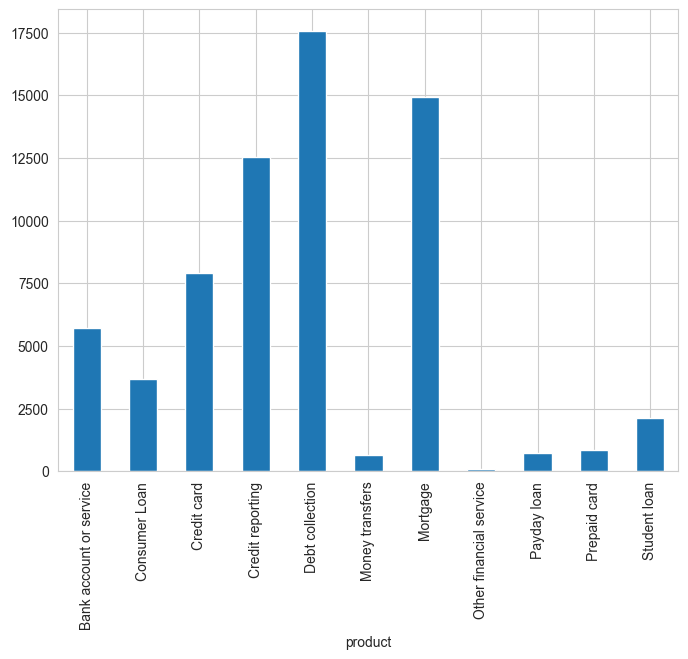

In [7]:
# Vamos plotar e ver como isso se apresenta
fig = plt.figure(figsize=(8,6))
Data.groupby('product')['consumer_complaint_narrative'].count().plot.bar(ylim=0)
plt.show()

A cobrança de dívidas e o crédito à habitação têm o maior número de reclamações registadas.

#### Etapa 1-5. Divida os dados
Divida os dados em treinamento e validação.

In [8]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['consumer_complaint_narrative'], Data['product'])

#### Etapa 1-6. Use TF-IDF para engenharia de recursos
Crie vetores TF-IDF, conforme discutido no Capítulo 3. Aqui, consideramos os recursos máximos como 5.000.

In [9]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word',
token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Data['consumer_complaint_narrative'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

#### Etapa 1-7. Construa o modelo e avalie
Vamos construir um classificador linear em vetores TF-IDF de nível de palavra. Os hiperparâmetros padrão são usados para o classificador. Parâmetros podem ser alterados como C, max_iter ou solver para obter melhores resultados.

In [10]:
model = linear_model.LogisticRegression(max_iter=1000).fit(xtrain_tfidf, train_y)

#Sumário
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100, multi_class="ovr", n_jobs=1,
                   penalty='l2', random_state=None, solver="liblinear", tol=0.0001,
                   verbose=0, warm_start=False)


LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [11]:
# Checando a acurácia
accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf), valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.844629385702311


In [12]:
# Relatório Classificação
# Classification report
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf),target_names=Data['product'].unique(),zero_division=False))

                         precision    recall  f1-score   support

        Debt collection       0.81      0.81      0.81      1419
          Consumer Loan       0.79      0.60      0.68       892
               Mortgage       0.80      0.81      0.80      1966
            Credit card       0.85      0.85      0.85      3168
       Credit reporting       0.82      0.89      0.85      4408
           Student loan       0.71      0.49      0.58       157
Bank account or service       0.92      0.95      0.94      3713
            Payday loan       0.00      0.00      0.00        29
        Money transfers       0.67      0.29      0.41       188
Other financial service       0.83      0.60      0.70       215
           Prepaid card       0.90      0.76      0.82       547

               accuracy                           0.84     16702
              macro avg       0.74      0.64      0.68     16702
           weighted avg       0.84      0.84      0.84     16702



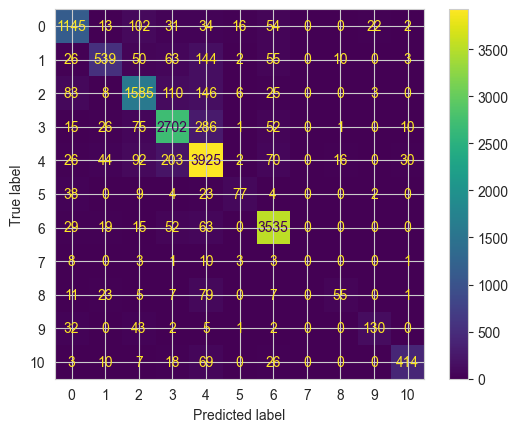

In [13]:
# matriz de Confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))

# Podemos utilizar o ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
plt.show()

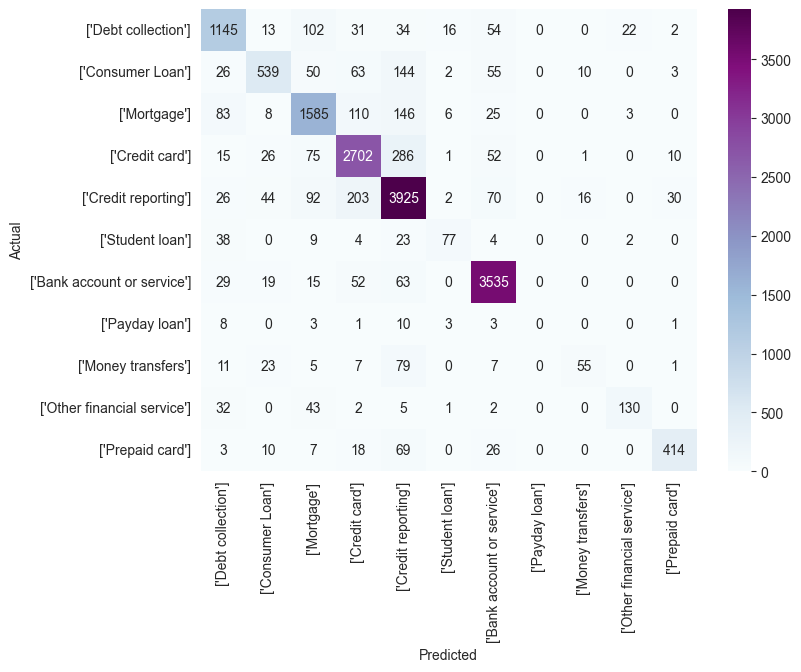

In [14]:
# Fazer a programação
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",
xticklabels=category_id_df[['product']].values,
yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

A precisão de 85% é boa para um modelo de linha de base. Precisão e recall parecem muito bons em todas as categorias, exceto para “empréstimo do dia de pagamento”. Se você procurar por empréstimo de carga útil, a maioria das previsões erradas são cobrança de dívidas e cartão de crédito, o que pode ser devido ao menor número de amostras nessa categoria. Também soa como uma subcategoria de um cartão de crédito. Você pode adicionar essas amostras a qualquer outro grupo para tornar o modelo mais estável. Vamos ver como é a previsão para um exemplo.

In [15]:
# Prediction example
texts = ["This company refuses to provide me verification and validation of debt" + "per my right under the FDCPA. I do not believe this debt is mine."]
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)
print(texts)
print(" - Predicted as: '{}'".format(id_to_category[predictions[0]]))

['This company refuses to provide me verification and validation of debtper my right under the FDCPA. I do not believe this debt is mine.']
 - Predicted as: 'Credit reporting'


Para aumentar a precisão, você pode fazer o seguinte.
* Reitere o processo com diferentes algoritmos como floresta aleatória, SVM, GBM, redes neurais, Naive Bayes.
* Técnicas de aprendizado profundo como RNN e LSTM (discutidas no Capítulo 6) também podem ser usadas.
* Em cada um desses algoritmos, existem muitos parâmetros a serem ajustados para obter melhores resultados. Isso pode ser feito facilmente por meio da pesquisa em grade, que tenta todas as combinações possíveis e oferece o melhor resultado.

## Receita 5-2. Implementando a Análise de Sentimento
Esta receita implementa, de ponta a ponta, uma aplicação industrial popular de NLP: análise de sentimento. Do ponto de vista comercial, é muito importante entender como é o feedback dos clientes sobre os produtos/serviços que eles oferecem para improvisar nos produtos/serviços para a satisfação do cliente.
### Problema
Você deseja implementar a análise de sentimento.
### Solução
A maneira mais simples é usar TextBlob ou a biblioteca vaderSentiment. Como você já usou o TextBlob, agora vamos usar o Vader.
### Como funciona
Siga as etapas nesta seção para implementar a análise de sentimento no problema de negócios.
#### Etapa 2-1. Defina o problema do negócio
Entenda como os produtos estão se saindo no mercado. Como os clientes estão reagindo a um determinado produto? Qual é o sentimento do consumidor em relação aos produtos? Muitas outras perguntas como essas podem ser respondidas usando a análise de sentimento.
#### Etapa 2-2. Identifique fontes de dados em potencial e extraia insights
Temos um conjunto de dados para análises de alimentos da Amazon. Vamos usar esses dados e extrair informações deles. Você pode baixar os dados em www.kaggle.com/snap/amazon-fine-food-reviews.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lendo os dados
df = pd.read_csv('D:\WILLIAN\OneDrive\Downloads\Reviews.csv')

# Lendo as linhas
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [17]:
# Entendendo os tipos de colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [18]:
df.Summary.head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [19]:
df.Text.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

#### Etapa 2-3. Pré-processar os dados
Você sabe a importância desta etapa. Execute uma tarefa de pré-processamento, conforme discutido no Capítulo 2.

In [20]:
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
# Lower casing and removing punctuations
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Text'] = df['Text'].str.replace('[^\w\s]','', regex=True)
df.Text.head(5)

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price there was a wide ...
Name: Text, dtype: object

In [21]:
# Removendo StopWords
stop = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.Text.head(5)

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

In [23]:
# Spelling correction
df['Text'] = df['Text'].apply(lambda x: str(TextBlob(x).correct()))
df.Text.head(5)

KeyboardInterrupt: 

In [24]:
# Lemmatization
df['Text'] = df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.Text.head(5)

KeyboardInterrupt: 

#### Etapa 2-4. Analisar dados
Esta etapa não está conectada em nenhum lugar na previsão de sentimentos; o que estamos tentando fazer aqui é aprofundar os dados e entendê-los.

In [ ]:
# Crie um novo quadro de dados "revisões" para realizar análises exploratórias de dados sobre ele
reviews = df
# Descartando valores nulos
reviews.dropna(inplace=True)
# O histograma revela que esse conjunto de dados é altamente desequilibrado em relação à classificação alta.
reviews.Score.hist(bins=5,grid=False)
plt.show()
print(reviews.groupby('Score').count().Id)

In [ ]:
# Para torná-los dados balanceados, amostramos cada pontuação pela menor contagem n acima. (ou seja, 29743 avaliações pontuadas como '2')
score_1 = reviews[reviews['Score'] == 1].sample(n=29743)
score_2 = reviews[reviews['Score'] == 2].sample(n=29743)
score_3 = reviews[reviews['Score'] == 3].sample(n=29743)
score_4 = reviews[reviews['Score'] == 4].sample(n=29743)
score_5 = reviews[reviews['Score'] == 5].sample(n=29743)

# Aqui recriamos um conjunto de dados 'balanceado'.
reviews_sample = pd.concat([score_1,score_2,score_3,score_4,score_5],axis=0)
reviews_sample.reset_index(drop=True,inplace=True)

Você pode usar esse conjunto de dados se estiver treinando seu próprio classificador de sentimento desde o início. E para fazer isso, você pode seguir os mesmos passos da classificação de texto (Receita 5-1). Aqui, nossa variável de destino seria positiva, negativa e neutra criada usando pontuação.
* Pontuação <= 2: Negativo
* Pontuação = 3: Neutro
* Pontuação > =4: Positivo

Dito isso, voltemos à nossa análise exploratória de dados.

In [ ]:
# A contagem de impressão por 'Score' para verificar o conjunto de dados agora está balanceada.
print(reviews_sample.groupby('Score').count().Id)

In [ ]:
# Vamos construir uma nuvem de palavras olhando para o texto 'Resumo'
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# A entrada da função Wordcloud precisa ser uma única string de texto.
# Aqui estou concatenando todos os Resumos em uma única string.
# Da mesma forma, você pode criar para a coluna de texto
reviews_str = reviews_sample.Summary.str.cat()
wordcloud = WordCloud(background_color='white').generate(reviews_str)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Agora vamos dividir os dados em Avaliações Negativas (Pontuação é 1 ou 2) e Positivas (4 ou 5).
negative_reviews = reviews_sample[reviews_sample['Score'].isin([1,2]) ]
positive_reviews = reviews_sample[reviews_sample['Score'].isin([4,5]) ]
# Transforme em string única
negative_reviews_str = negative_reviews.Summary.str.cat()
positive_reviews_str = positive_reviews.Summary.str.cat()
# Crie nuvens de palavras
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_str)
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)

#plotando
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Reviews with Negative Scores',fontsize=20)
ax2 = fig.add_subplot(212)
ax2.imshow(wordcloud_positive,interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Reviews with Positive Scores',fontsize=20)
plt.show()

#### Etapa 2-5. Use um modelo pré-treinado
Esta etapa não é necessária porque não estamos construindo o modelo do zero; em vez disso, usamos o modelo pré-treinado da biblioteca **vaderSentiment**.

Se quiser construir o modelo do zero, você pode aproveitar as classes positivas e negativas criadas enquanto explora como uma variável de destino e, em seguida, treina o modelo. Você pode seguir as mesmas etapas da classificação de texto explicada na Receita 5-1 para criar um classificador de sentimento do zero.
#### Etapa 2-6. Fazer análise de sentimento
Na análise de sentimento, o modelo pré-treinado obtém a entrada da descrição do texto e gera a pontuação de sentimento variando de –1 a +1 para cada frase.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sys
import ast
plt.style.use('fivethirtyeight')
# Função para obter o sentimento
cp = sns.color_palette()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Gerando sentimento para todas as frases presentes no conjunto de dados
emptyline=[]
for row in df['Text']:
    vs=analyzer.polarity_scores(row)
    emptyline.append(vs)

# Criando novo dataframe com sentimentos
df_sentiments=pd.DataFrame(emptyline)
df_sentiments.head(5)

In [ ]:
# Mesclando os sentimentos de volta ao quadro de dados de comentários
df_c = pd.concat([df.reset_index(drop=True),df_sentiments], axis=1)
df_c.head(3)


In [ ]:
# Converter pontuações em sentimentos positivos e negativos usando algum limite
df_c['Sentiment'] = np.where(df_c['compound'] >= 0 , 'Positive', 'Negative')
df_c.head(5)

#### Etapa 2-7. Obtenha insights de negócios
Vamos ver como o sentimento geral está usando o sentimento que geramos.

In [ ]:
result=df_c['Sentiment'].value_counts()
result.plot(kind='bar', rot=0, color='blue')
plt.show()

Acabamos de pegar uma amostra de 1.000 comentários e concluímos a análise de sentimento. Se você olhar, mais de 900 (>90%) avaliações são positivas, o que é bom para qualquer negócio. Você também pode agrupar subprodutos, ou seja, subprodutos de sentimentos para entender o feedback de alto nível do cliente em relação aos produtos.

In [ ]:
# Exemplo de trecho de código
result=df_c.groupby('ProductId')['Sentiment'].value_counts().unstack()
result[['Negative','Positive']].plot(kind='bar', rot=0,color='rb')

Da mesma forma, você pode analisar sentimentos por mês usando a coluna de tempo e muitos outros atributos.

## Receita 5-3. Aplicando funções de similaridade de texto
Esta receita abrange a junção de dados usando similaridade de texto.
### Problema
Você tem várias tabelas no banco de dados e, às vezes, não haverá um ID comum ou KEY para se juntar a eles, inclusive em cenários como o seguinte.
* Informações do cliente espalhadas por várias tabelas e sistemas
* Nenhuma chave global para vinculá-los todos juntos
* Muitas variações de nomes e endereços

### Solução
Isso pode ser resolvido aplicando funções de similaridade de texto nas colunas demográficas, como nome, sobrenome, endereço e assim por diante. E com base na pontuação de similaridade em algumas colunas comuns, você pode decidir se o par de registros corresponde ou não.
### Como funciona
Siga as etapas nesta seção para vincular os registros.
A seguir estão os desafios técnicos.
* Registros enormes que precisam ser vinculados/unidos/desduplicados.
* Os registros vêm de vários sistemas com esquemas diferentes.

Não há chave global ou ID de cliente para mesclar. Há dois cenários possíveis de junção de dados ou vinculação de registros.
* Vários registros do mesmo cliente na mesma mesa e você deseja desduplicar.
* Os registros dos mesmos clientes de várias tabelas precisam ser mesclados.

Para a receita 3a, vamos resolver o cenário 1, que é a desduplicação e, como parte da receita 3b, vamos resolver o cenário 2, que é a vinculação de registros de várias tabelas.
**Desduplicação na mesma tabela**
#### Etapa 3a-1. Leia e entenda os dados
Primeiro, você precisa dos dados.

In [25]:
import recordlinkage

# Para esta demonstração, vamos usar o conjunto de dados integrado da biblioteca recordlinkage
# Importar conjunto de dados

from recordlinkage.datasets import load_febrl1

#criar um dataframe - dfa
dfA = load_febrl1()
dfA.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-223-org,NaN,waller,6,tullaroop street,willaroo,st james,4011,wa,19081209,6988048
rec-122-org,lachlan,berry,69,giblin street,killarney,bittern,4814,qld,19990219,7364009
rec-373-org,deakin,sondergeld,48,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210,2635962
rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612,9004242
rec-227-org,luke,purdon,23,ramsay place,mirani,garbutt,2260,vic,19831024,8099933


#### Etapa 3a-2. Extrair uma chave de bloqueio
Reduza a janela de comparação e crie pares de registros.
* Existe um número muito grande de registros; digamos, 100 milhões de registros significam (100 milhões, escolha 2) ≈ 10^16 pares possíveis
* Uma heurística é necessária para reduzir rapidamente 10^16 sem perder muitas correspondências

Isso pode ser feito extraindo uma chave de bloqueio. O seguinte é um exemplo.
* Registro: primeiro nome: John, sobrenome: Roberts, endereço: 20 Main St Plainville MA 01111
* Chave de bloqueio: primeiro nome - John
* Emparelhado com: John Ray ... 011
* Não será emparelhado com: Frank Sinatra . .. 07030
* Gerar pares apenas para registros no mesmo bloco

Aqui, o bloqueio é feito na coluna “Sndx-SN”, que é o valor Soundex da coluna sobrenome, conforme discutido no Capítulo 4.

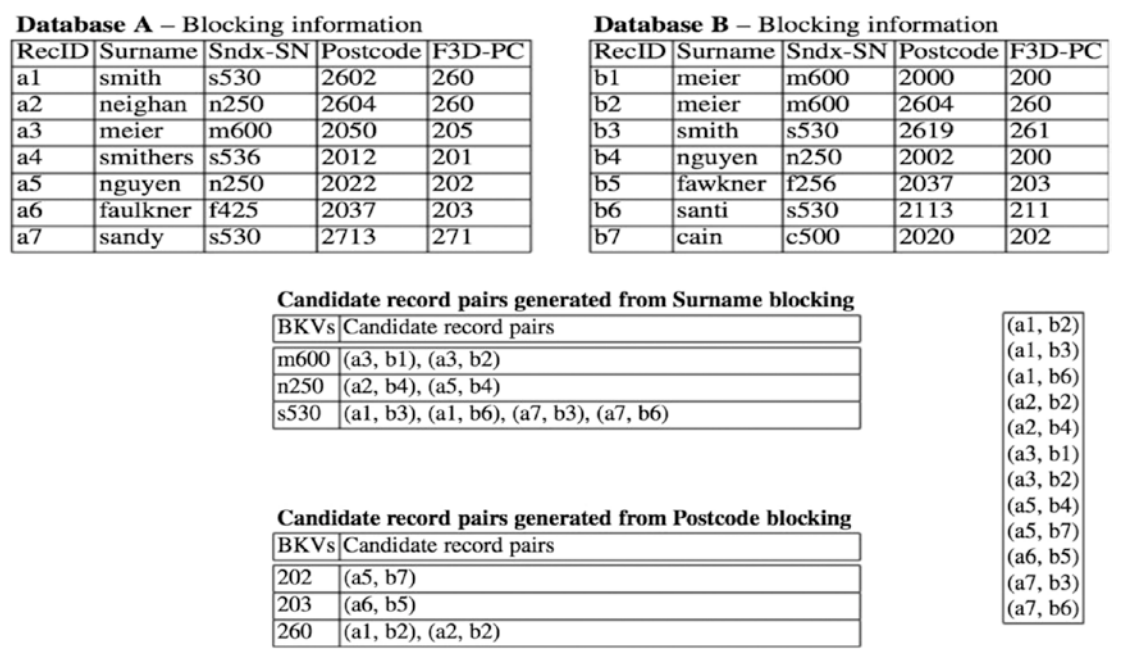

In [26]:
from IPython.display import Image
Image('images/chave_bloqueio.PNG')

Existem muitas técnicas avançadas de bloqueio, também, como as seguintes.
* Bloqueio padrão
  * Coluna única
  * Colunas múltiplas
* Vizinhança classificada
  * Q-gram: bloqueio difuso
  * LSH
  * Clustering Canopy

Este pode ser um tópico totalmente novo, mas, por enquanto, vamos construir os pares usando o primeiro nome como o índice de bloqueio.

In [35]:
import recordlinkage as rl
indexer = rl.Index()
indexer.block('given_name')
indexer.block('given_name')
pairs = indexer.index(dfA)
print (len(pairs))

2082


#### Etapa 3a-3. Fazer correspondência e pontuação de similaridade
Aqui calculamos as pontuações de similaridade nas colunas como nome, sobrenome e endereço entre os pares de registros gerados na etapa anterior. Para colunas como data de nascimento, bairro e estado, usamos a correspondência exata, pois é importante que essa coluna possua registros exatos.

Usamos Jaro-Winkler, mas você pode usar qualquer uma das outras medidas de similaridade discutidas no Capítulo 4.

In [36]:
# Esta célula pode levar algum tempo para computar.
compare_cl = recordlinkage.Compare()
compare_cl.string('given_name', 'given_name',method='jarowinkler',
label="given_name")
compare_cl.string('surname', 'surname', method="jarowinkler",
label="surname")
compare_cl.exact('date_of_birth', 'date_of_birth', label="date_of_birth")
compare_cl.exact('suburb', 'suburb', label="suburb")
compare_cl.exact('state', 'state', label="state")
compare_cl.string('address_1', 'address_1',method='jarowinkler',
label="address_1")
features = compare_cl.compute(pairs, dfA)
features.sample(5)

,,given_name,surname,date_of_birth,suburb,state,address_1
rec_id_1,rec_id_2,,,,,,
rec-301-org,rec-465-dup-0,1.0,0.646429,0,0,1,0.000000
rec-477-dup-0,rec-245-org,1.0,0.555556,0,0,0,0.616667
rec-444-org,rec-352-dup-0,1.0,0.490079,0,0,0,0.629085
rec-201-org,rec-167-org,1.0,0.466667,0,0,0,0.379798
rec-449-org,rec-174-dup-0,1.0,0.550000,0,0,0,0.501068


Aqui, o registro “rec-115-dup-0” é comparado com “rec-120-dup-0”. Como o primeiro nome (coluna de bloqueio) corresponde, as pontuações de similaridade são calculadas nas colunas comuns para esses pares.

#### Etapa 3a-4. Prever se os registros correspondem usando o classificador ECM
O seguinte é um método de aprendizado não supervisionado para calcular a probabilidade de correspondência dos registros.

In [51]:
# Selecione todos os recursos, exceto o Given_name, pois é nossa chave de bloqueio
features1 = features[['suburb','state','surname','date_of_birth','address_1']]

# Aprendizado não supervisionado – probabilístico
ecm = recordlinkage.ECMClassifier()
result_ecm = ecm.fit_predict((features1).astype(int),recordlinkage.set_option('classification.return_type', 'series'))
result_ecm

rec_id_1      rec_id_2      
rec-1070-org  rec-3024-dup-0    0
              rec-2371-dup-0    0
              rec-4652-dup-0    0
              rec-4795-dup-0    0
              rec-1314-dup-0    0
                               ..
rec-4528-org  rec-4528-dup-0    1
rec-4887-org  rec-4887-dup-0    1
rec-4350-org  rec-4350-dup-0    1
rec-4569-org  rec-4569-dup-0    1
rec-3125-org  rec-3125-dup-0    1
Name: classification, Length: 77249, dtype: int32

A saída mostra claramente que “rec-183-dup-0” corresponde a “rec-183-org” e pode ser vinculado a um ID global. O que fizemos até agora é chamado de desduplicação: identificar vários registros dos mesmos usuários na tabela individual.
#### Registros dos mesmos clientes de várias tabelas
A seguir, veremos como você pode resolver esse problema se os registros estiverem em várias tabelas sem IDs exclusivos para mesclar.

#### Etapa 3b-1. Leia e entenda os dados
Vamos usar o conjunto de dados integrado da biblioteca recordlinkage.

In [43]:
from recordlinkage.datasets import load_febrl4
dfA, dfB = load_febrl4()
dfA.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688


In [44]:
dfB.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-561-dup-0,elton,NaN,3,light setreet,pinehill,windermere,3212,vic,19651013,1551941
rec-2642-dup-0,mitchell,maxon,47,edkins street,lochaoair,north ryde,3355,nsw,19390212,8859999
rec-608-dup-0,NaN,white,72,lambrigg street,kelgoola,broadbeach waters,3159,vic,19620216,9731855
rec-3239-dup-0,elk i,menzies,1,lyster place,NaN,northwood,2585,vic,19980624,4970481
rec-2886-dup-0,NaN,garanggar,NaN,may maxwell crescent,springettst arcade,forest hill,2342,vic,19921016,1366884


#### Etapa 3b-2. Bloco para reduzir a janela de comparação e criar pares de registros
Isso é o mesmo explicado anteriormente, considerando o Given_name como um índice de bloqueio.

In [46]:
import recordlinkage as rl
indexer = rl.Index()
indexer.block('given_name')
indexer.block('given_name')
pairs = indexer.index(dfA, dfB)

#### Etapa 3b-3. Fazer correspondência de similaridade
A explicação continua a mesma.

In [47]:
compare_cl = recordlinkage.Compare()
compare_cl.string('given_name', 'given_name',method='jarowinkler',
label="given_name")
compare_cl.string('surname', 'surname', method="jarowinkler",
label="surname")
compare_cl.exact('date_of_birth', 'date_of_birth', label="date_of_birth")
compare_cl.exact('suburb', 'suburb', label="suburb")
compare_cl.exact('state', 'state', label="state")
compare_cl.string('address_1', 'address_1',method='jarowinkler',
label="address_1")
features = compare_cl.compute(pairs, dfA, dfB)
features.head(10)

given_name   surname  date_of_birth  suburb  \
rec_id_1     rec_id_2                                                      
rec-1070-org rec-3024-dup-0         1.0  0.436508              0       0   
             rec-2371-dup-0         1.0  0.490079              0       0   
             rec-4652-dup-0         1.0  0.490079              0       0   
             rec-4795-dup-0         1.0  0.000000              0       0   
             rec-1314-dup-0         1.0  0.000000              0       0   
rec-2371-org rec-3024-dup-0         1.0  0.527778              0       0   
             rec-2371-dup-0         1.0  1.000000              1       1   
             rec-4652-dup-0         1.0  0.500000              0       0   
             rec-4795-dup-0         1.0  0.527778              0       0   
             rec-1314-dup-0         1.0  0.527778              0       0   

                             state  address_1  
rec_id_1     rec_id_2                          
rec-1070-org rec-3024-dup-0      1   0.000000  
             rec-2371-dup-0      0   0.715873  
             rec-4652-dup-0      0   0.645604  
             rec-4795-dup-0      1   0.552381  
             rec-1314-dup-0      1   0.618254  
rec-2371-org rec-3024-dup-0      0   0.000000  
             rec-2371-dup-0      1   1.000000  
             rec-4652-dup-0      1   0.635684  
             rec-4795-dup-0      0   0.411111  
             rec-1314-dup-0      0   0.672222

Portanto, aqui o registro “rec-1070-org” é comparado com “rec-3024-dup-0”, “rec-2371-dup-0”, “rec-4652-dup-0”, “rec-4795-dup- 0” e “rec-1314-dup-0, uma vez que seu primeiro nome (coluna de bloqueio) é correspondente e as pontuações de similaridade são calculadas nas colunas comuns para esses pares.
#### Etapa 3b-4. Preveja se os registros correspondem usando o classificador ECM
O seguinte é um método de aprendizado não supervisionado para calcular a probabilidade de que o registro seja uma correspondência.

In [50]:
# selecione todos os recursos, exceto o Given_name, pois é nossa chave de bloqueio
features1 = features[['suburb','state','surname','date_of_birth','address_1']]
# aprendizado não supervisionado - probabilístico
ecm = recordlinkage.ECMClassifier()
result_ecm = ecm.fit_predict((features1).astype(int),return_type = recordlinkage.set_option('classification.return_type', 'series'))
result_ecm

rec_id_1      rec_id_2      
rec-1070-org  rec-3024-dup-0    0
              rec-2371-dup-0    0
              rec-4652-dup-0    0
              rec-4795-dup-0    0
              rec-1314-dup-0    0
                               ..
rec-4528-org  rec-4528-dup-0    1
rec-4887-org  rec-4887-dup-0    1
rec-4350-org  rec-4350-dup-0    1
rec-4569-org  rec-4569-dup-0    1
rec-3125-org  rec-3125-dup-0    1
Name: classification, Length: 77249, dtype: int32

A saída mostra claramente que “rec-122-dup-0” corresponde a “rec-122-org” e pode ser vinculado a um ID global.

Dessa forma, você pode criar um data lake que consiste em um ID global exclusivo e dados consistentes nas tabelas e realizar análises estatísticas.

## Receita 5-4. Resumindo dados de texto
Se você apenas olhar ao redor, há muitos artigos e livros disponíveis. Vamos supor que você queira aprender um conceito de NLP e, se pesquisar no Google, encontrará um artigo. Você gosta do conteúdo do artigo, mas é muito longo para lê-lo mais uma vez. Você deseja resumir o artigo e salvá-lo em algum lugar para poder lê-lo mais tarde.

Bem, a NLP tem uma solução para isso. O resumo de texto ajuda a fazer isso. Você não precisa ler o artigo completo ou o livro todas as vezes.
### Problema
Resumo do texto do artigo/documento usando diferentes algoritmos em Python.

### Solução
A sumarização de texto é o processo de transformar documentos grandes em menores sem perder o contexto, o que acaba economizando tempo do leitor. Isso pode ser feito usando diferentes técnicas como as seguintes
* TextRank: um algoritmo de classificação baseado em gráfico
* Resumo de texto baseado em recursos
* LexRank: TF-IDF com um algoritmo baseado em gráfico
* Baseado em tópicos
* Usando incorporações de sentenças
* Modelo codificador-decodificador: técnicas de aprendizado profundo

### Como funciona
Explore o primeiro duas abordagens nesta receita.
#### Etapa 4-1. Use TextRank
TextRank é o algoritmo de classificação baseado em gráfico para NLP. É inspirado no PageRank, que é usado no mecanismo de busca do Google, mas especialmente projetado para texto. Ele extrai os tópicos, cria nós a partir deles e captura a relação entre os nós para resumir o texto.

Vamos ver como fazer isso usando o pacote gensim do Python. A função é resumir.

Primeiro, vamos importar as notas. Digamos que você esteja lendo um artigo da Wikipédia sobre processamento de linguagem natural.

In [52]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Função para obter dados da Wikipédia
def get_only_text(url):
    page = urlopen(url)
    soup = BeautifulSoup(page)
    text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
    print (text)
    return soup.title.text, text

# Mencione a url da Wikipédia
url="https://en.wikipedia.org/wiki/Natural_language_processing"
# Chame a função criada acima
text = get_only_text(url)

# Conta o número de letras
len(''.join(text))

Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data.  The goal is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.
 Challenges in natural language processing frequently involve speech recognition, natural-language understanding, and natural-language generation.
 Natural language processing has its roots in the 1950s. Already in 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence, though at the time that was not articula

9004

In [53]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(text=text[1])

In [54]:
# create dictionary
word_dict = {}
# loop through every sentence and give it a weight
for word in doc:
    word = word.text.lower()
    if word in word_dict:
        word_dict[word] += 1
    else:
        word_dict[word] = 1

# create a list of tuple (sentence text, score, index)
sents = []
# score sentences
sent_score = 0
for index, sent in enumerate(doc.sents):
    for word in sent:
        word = word.text.lower()
        sent_score += word_dict[word]
    sents.append((sent.text.replace("\n", " "), sent_score/len(sent), index))

# sort sentence by word occurrences
sents = sorted(sents, key=lambda x: -x[1])
# return top 20
sents = sorted(sents[:20], key=lambda x: x[2])

# compile them into text
summary_text = ""
for sent in sents:
    summary_text += sent[0] + " "

print(summary_text)

            The cache language models upon which many speech recognition systems now rely are examples of such statistical models.      Since the neural turn, statistical methods in NLP research have been largely replaced by neural networks. However, they continue to be relevant for contexts in which statistical interpretability and transparency is required.   A major drawback of statistical methods is that they require elaborate feature engineering. Since 2015,[19] the field has thus largely abandoned statistical methods and shifted to neural networks for machine learning.    The following is a list of some of the most commonly researched tasks in natural language processing. Though natural language processing tasks are closely intertwined, they can be subdivided into categories for convenience. A coarse division is given below.   Based on long-standing trends in the field, it is possible to extrapolate future directions of NLP. Cognition refers to "the mental action or process of acq

In [55]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words


LANGUAGE = "english"
SENTENCES_COUNT = 5
url = url="https://en.wikipedia.org/wiki/Natural_language_processing"
parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

However, there is an enormous amount of non-annotated data available (including, among other things, the entire content of the World Wide Web), which can often make up for the inferior results if the algorithm used has a low enough time complexity to be practical.
The machine-learning paradigm calls instead for using statistical inference to automatically learn such rules through the analysis of large corpora(the plural form of corpus, is a set of documents, possibly with human or computer annotations) of typical real-world examples.
Increasingly, however, research has focused on statistical models, which make soft, probabilistic decisions based on attaching real-valued weights to each input feature (complex-valued embeddings,[17] and neural networks in general have also been proposed, for e.g. speech[18]).
Language Log, February 5, 2011.^"Investigating complex-valued representation in NLP"(PDF).^ Trabelsi, Chiheb; Bilaniuk, Olexa; Zhang, Ying; Serdyuk, Dmitriy; Subramanian, Sandeep; S

In [56]:
# Um texto em portugues

LANGUAGE = 'portuguese'
SENTENCES_COUNT = 2
parser = PlaintextParser.from_file("noticia.txt", Tokenizer(LANGUAGE))

stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

Um homem, ainda não identificado, foi agredido por moradores após tentar roubar uma motocicleta, na tarde deste domingo (13), na Rua Brasília, bairro Coroado, Zona Leste de Manaus.
Segundo a equipe de plantão da 11ª Companhia Interativa Comunitária (Cicom), moradores da Rua Brasília perceberam que o homem estava tentando roubar uma motocicleta, que estava estacionada na via.


#### Estapa 4-2. Use o resumo de texto baseado em recursos
Seus métodos de resumo de texto baseados em recursos extraem um recurso da frase e verificam a importância de classificá-lo. Posição, comprimento, frequência de termo, entidade nomeada e muitos outros recursos são usados para calcular a pontuação. O algoritmo de Luhn é um dos algoritmos baseados em recursos. Vejamos como implementá-lo usando a biblioteca sumy.

In [57]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.luhn import LuhnSummarizer as Summarizer

# Extracting and summarizing
LANGUAGE = "english"
SENTENCES_COUNT = 5
url="https://en.wikipedia.org/wiki/Natural_language_processing"
parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)
summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

Increasingly, however, research has focused on statistical models, which make soft, probabilistic decisions based on attaching real-valued weights to each input feature (complex-valued embeddings,[17] and neural networks in general have also been proposed, for e.g. speech[18]).
However, part-of-speech tagging introduced the use of hidden Markov models to natural language processing, and increasingly, research has focused on statistical models, which make soft, probabilistic decisions based on attaching real-valued weights to the features making up the input data.
Implicit semantic role labelling Given a single sentence, identify and disambiguate semantic predicates (e.g., verbal frames) and their explicit semantic roles in the current sentence (see Semantic role labelling above).
Interest on increasingly abstract, "cognitive" aspects of natural language (1999–2001: shallow parsing, 2002–03: named entity recognition, 2006–09/2017–18: dependency syntax, 2004–05/2008–09 semantic role labe

In [58]:
# Um texto em portugues

LANGUAGE = 'portuguese'
SENTENCES_COUNT = 3
parser = PlaintextParser.from_file("noticia.txt", Tokenizer(LANGUAGE))

stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

Flordelis dos Santos Souza: condenada a 50 anos e 28 dias por homicídio triplamente qualificado, tentativa de homicídio duplamente qualificado, uso de documento falso e associação criminosa armada.
Simone dos Santos Rodrigues: condenada a 31 anos e 4 meses por homicídio triplamente qualificado, tentativa de homicídio duplamente qualificado e associação criminosa armada.
Adriano dos Santos Rodrigues: condenado a 4 anos, 6 meses e 20 dias em regime semiaberto por uso de documento falso duas vezes e por associação criminosa armada.


Problema resolvido. Agora você não precisa ler todas as notas; apenas leia o resumo sempre que estivermos com pouco tempo. Você pode usar técnicas de aprendizado profundo para obter melhor precisão e melhores resultados, como o modelo codificador-decodificador. Você verá como fazer isso no próximo capítulo.

Embora vejamos diferenças de resumos, teremos que adequar o melhor às nossas necessidades.

## Receita 5-5. Agrupamento de Documentos
O agrupamento de documentos, também chamado de agrupamento de texto, é uma análise de agrupamento de documentos textuais. Um dos usos típicos seria o gerenciamento de documentos.
### Problema
Você deseja agrupar ou agrupar os documentos com base em padrões e semelhanças.
### Solução
O agrupamento de documentos inclui etapas semelhantes.
1. Tokenização.
2. Stemming e lematização.
3. Remoção de palavras de parada e pontuação.
4. Calculando frequências de termo ou TF-IDF.
5. Agrupamento: k-means/hierárquico. Você pode usar qualquer um dos algoritmos de agrupamento para agrupar diferentes documentos com base nos recursos que geramos
6. Avaliação e visualização: Os resultados do agrupamento podem ser visualizados plotando os agrupamentos em um espaço bidimensional.
### Como funciona
#### Etapa 5-1. Importar dados e bibliotecas
A seguir estão as bibliotecas, seguidas pelos dados.

In [60]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

In [61]:
#Vamos usar o mesmo conjunto de dados de reclamações que usamos para classificação
Data = pd.read_csv("D:\WILLIAN\OneDrive\Downloads\consumer_complaints.csv",encoding='latin-1', low_memory=False)
#selecionar colunas e linhas necessárias
Data = Data[['consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]
# vamos fazer o agrupamento de apenas 200 documentos. É mais fácil de interpretar.
Data_sample=Data.sample(200)


#### Etapa 5-2. Pré-processar e usar a engenharia de recursos TF-IDF
Agora vamos pré-processá-lo.

In [62]:
# Remova o símbolo indesejado
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX','')

# Converter dataframe para lista
complaints = Data_sample['consumer_complaint_narrative'].tolist()

# cria a classificação dos documentos – vamos usá-la mais tarde
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)

# Stop Words
stopwords = nltk.corpus.stopwords.words('english')

# Carregar 'stemmer'
stemmer = SnowballStemmer("english")

# Funções para tokenizer de sentença, para remover tokens numéricos e linha
# pontuação
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                   max_features=200000,
                                   min_df=0.2,
                                   stop_words='english',
                                   use_idf=True,
                                   tokenizer=tokenize_and_stem,
                                   ngram_range=(1,3))

#ajuste o vetorizador aos dados
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names_out()
print(tfidf_matrix.shape)

D:\WILLIAN\Anaconda3\envs\NLP_Recipes\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


(200, 36)


#### Etapa 5-3. Cluster usando k-means
Vamos começar o agrupamento.

In [63]:
from sklearn.cluster import KMeans
# Defina o número de cluster
num_clusters = 6

# Rodando o algoritmo de clusterização
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

# clusters final
clusters = km.labels_.tolist()
complaints_data = { 'rank': ranks, 'complaints': complaints,
'cluster': clusters }
frame = pd.DataFrame(complaints_data,
                     index = [clusters] ,
                     columns =['rank', 'cluster']
                     )

#number of docs per cluster
frame['cluster'].value_counts()

1    45
2    37
4    33
5    29
0    28
3    28
Name: cluster, dtype: int64

#### Etapa 5-4. Identifique o comportamento do cluster
Identifique as cinco primeiras palavras que estão mais próximas do centróide do cluster.

In [64]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Cluster 0 words: b'account', b'bank', b'days', b"'s", b'credit', b'state',
Cluster 1 words: b'credit', b'report', b'credit', b'inform', b'account', b'file',
Cluster 2 words: b'time', b'years', b'told', b'received', b'number', b'paid',
Cluster 3 words: b'payment', b'months', b'mortgage', b"n't", b'pay', b'loan',
Cluster 4 words: b'debt', b'collect', b'company', b'received', b'credit', b'letter',
Cluster 5 words: b'loan', b'mortgage', b'bank', b"'s", b'time', b'payment',


#### Etapa 5-5. Plote os clusters em um gráfico 2D
Por fim, plote os clusters.

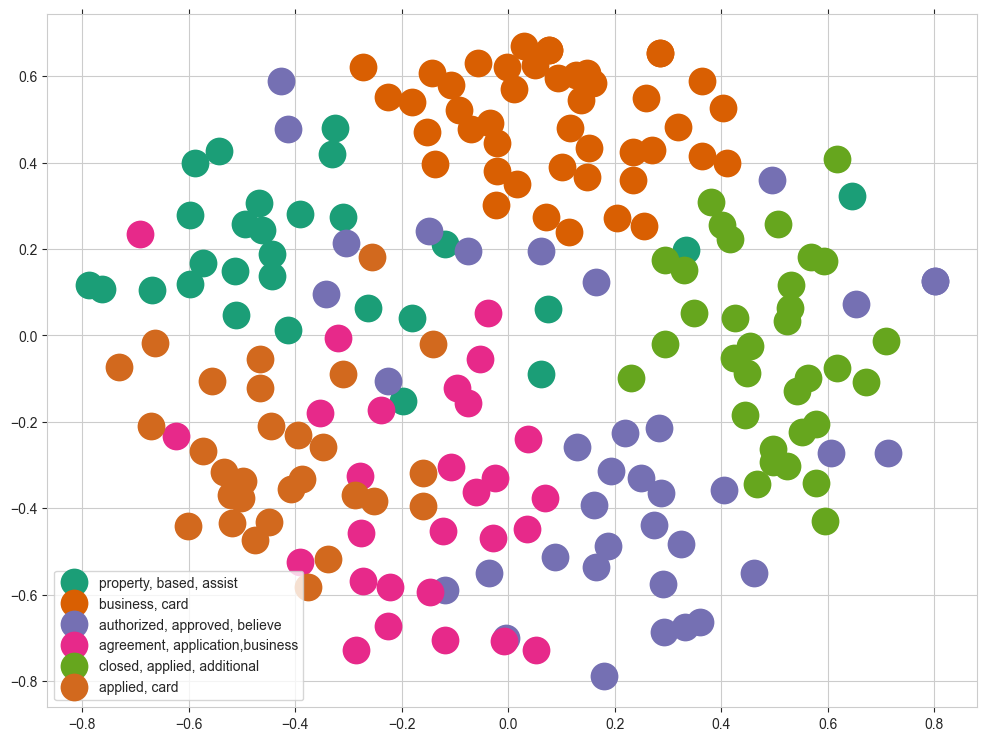

In [65]:
# Similaridade
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Converta dois componentes enquanto plotamos pontos em um plano bidimensional
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(similarity_distance) # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#Configurar cores por clusters usando um dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}

# configurar nomes de cluster usando um dict
cluster_names = {0: 'property, based, assist',
                 1: 'business, card',
                 2: 'authorized, approved, believe',
                 3: 'agreement, application,business',
                 4: 'closed, applied, additional',
                 5: 'applied, card'}

# Cria data frame que tem o resultado do MDS e do cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')

# Configurar plotagem
fig, ax = plt.subplots(figsize=(12, 9)) # set size
for name, group in groups:
    ax.plot(group.x, group.y, marker="o", linestyle='', ms=20, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params( axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1)
plt.show()

Existem 200 reclamações agrupadas em seis grupos usando agrupamento k-means. Ele agrupa tipos semelhantes de reclamações em seis grupos usando o TF-IDF. Você também pode usar a palavra embeddings e resolver isso para obter melhores clusters. Os gráficos 2D fornecem uma visão fácil de entender sobre o comportamento do cluster. Você vê que os pontos da mesma cor (docs) estão localizados mais próximos uns dos outros.

## Receita 5-6. NLP em um mecanismo de busca
Esta receita discute o que é necessário para construir um mecanismo de busca do ponto de vista da NLP. Entretanto, a implementação está além do escopo deste livro.
### Problema
Você deseja conhecer a arquitetura e o pipeline de NLP para construir um mecanismo de pesquisa.
### Solução
A Figura 5-1 mostra todo o processo. Cada etapa é explicada na seção "Como funciona".

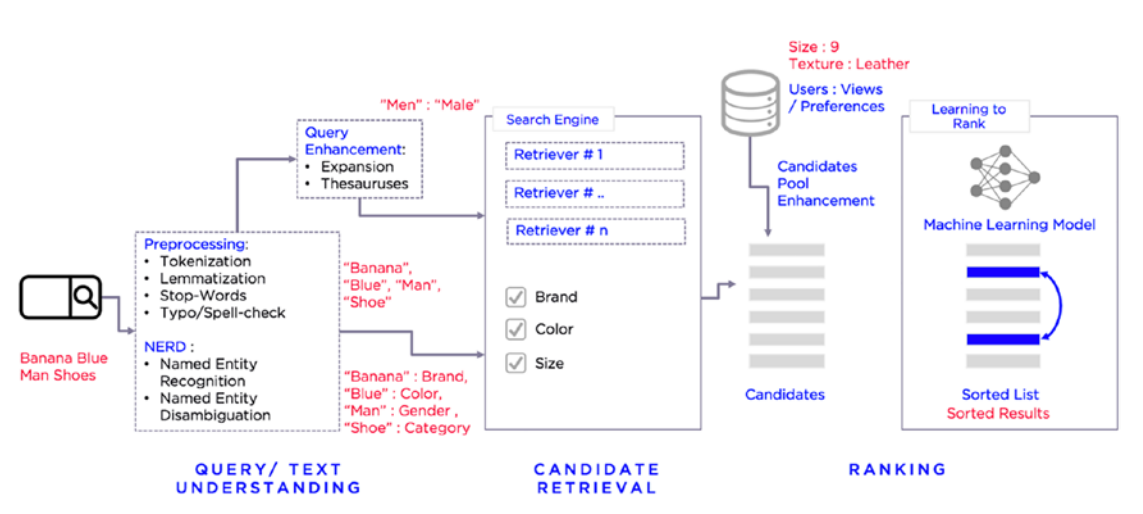

In [66]:
from IPython.display import Image
Image('images/NLP_search_engine.png')

### Como funciona
Siga a arquitetura passo a passo para construir um mecanismo de busca do ponto de vista do NLP.
#### Etapa 6-1. Pré-processamento
Sempre que o usuário insere a consulta de pesquisa, ela é passada para o pipeline de pré-processamento do NLP.
1. Remoção de ruído e palavras de parada
2. Tokenização
3. Stemming
4. Lematização

#### Etapa 6-2. Use o modelo de extração de entidade
A saída do pipeline é alimentada no modelo de extração de entidade. Você pode criar o modelo de reconhecimento de entidade personalizado usando qualquer uma das bibliotecas como StanfordNER ou NLTK.

Ou você pode criar um modelo de reconhecimento de entidade do zero usando campos aleatórios condicionais ou modelos de Markov.

Por exemplo, suponha que você esteja construindo um mecanismo de busca para um gigante do comércio eletrônico. A seguir estão as entidades nas quais você pode treinar o modelo.
* Sexo
* Cor
* Marca
* Categoria do produto
* Tipo de produto
* Preço
* Tamanho

Você pode criar a desambiguação de entidades nomeadas usando estruturas de aprendizagem profunda como RNN e LSTM. Isso é muito importante para o extrator de entidades entender o conteúdo no qual as entidades são utilizadas. Por exemplo, *rosa* pode ser uma *cor* ou uma *marca*. O NED ajuda nessa desambiguação.

Etapas de construção do modelo NERD.
* Limpeza e pré-processamento de dados
* Treinamento do modelo NER
* Teste e validação

Formas de implantação para treinar/construir o modelo NERD
* Reconhecimento e desambiguação de entidade nomeada
* Stanford NER com personalização
* Rede neural recorrente (RNN) – LSTM (longo prazo memória) para usar o contexto para desambiguação
* Reconhecimento conjunto de entidade nomeada e desambiguação

#### Etapa 6-3. Fazer aprimoramento/expansão da consulta
É muito importante entender os possíveis sinônimos das entidades para garantir que os resultados da pesquisa não percam relevância potencial. Por exemplo, os sapatos masculinos também podem ser chamados de sapatos masculinos, calçados esportivos masculinos, sapatos formais masculinos, mocassins masculinos ou tênis masculinos. **Use a incorporação de palavras treinadas localmente (usando o modelo word2vec/GloVe) para conseguir isso**.
#### Etapa 6-4. Use uma plataforma de pesquisa
As plataformas de pesquisa, como *Solr* ou *Elasticsearch*, têm recursos importantes que incluem destaque de ocorrências de pesquisa de texto completo, pesquisa facetada, indexação em tempo real, agrupamento dinâmico e integração de banco de dados. Isso não está relacionado à NLP. Do ponto de vista do aplicativo de ponta a ponta, acabamos de apresentar a você o que é.
#### Etapa 6-5. Aprenda a classificar
Depois que os resultados da pesquisa são obtidos do *Solr* ou *Elasticsearch*, eles devem ser classificados com base nas preferências do usuário usando os comportamentos anteriores.

## Receita 5-7. Detectando notícias falsas
Na era das mídias sociais, as notícias falsas estão apresentando muitos problemas. É claro que ninguém imaginaria que as fake news seriam um dos maiores problemas dessa era. Mas, como todos os problemas, a ciência de dados também tem uma solução para esse problema, se não com grande precisão, com alguma precisão aceitável.
### Problema
Por que as notícias falsas são um problema importante a ser resolvido? A criação e disseminação de notícias falsas aumentaram significativamente nos últimos anos, principalmente em plataformas de mídia social como WhatsApp, Facebook e Instagram. Notícias falsas podem ocorrer em qualquer tipo de notícia — política, local, saúde, entretenimento, questões relacionadas à tecnologia e muito mais. Muitas decisões erradas foram tomadas com base em notícias falsas que não foram validadas. É um desafio diferenciar entre notícias falsas e reais. O objetivo é construir um modelo de classificação binária que possa diferenciar entre notícias genuínas e notícias falsas com base no conteúdo.
### Solução
É um problema de classificação binária. Há uma classe para notícias falsas e outra classe para notícias genuínas. Há um conjunto de documentos de texto junto com as aulas. A seguir estão as etapas para resolver o problema.
1. Primeiro, converta os dados brutos em um quadro de dados para processamento posterior.
2. Pré-processe e limpe os dados de texto.
3. Após a limpeza dos dados, a engenharia de recursos é realizada.
4. Os dados são explorados para descobrir insights em potencial.
5. Esses recursos constroem o modelo, neste caso, um modelo classificador usando algoritmos como regressão logística, floresta aleatória, Naïve Bayes, SVM e muito mais.
6. Os hiperparâmetros do modelo são ajustados e avaliados. Por fim, os resultados do modelo são validados.

### Como Funciona
#### Etapa 7-1. Coletar dados
Vamos usar o conjunto de dados de fonte gratuita em http://web.eecs.umich.edu/~mihalcea/downloads/ fakeNewsDatasets.zip/. Uma pequena parte dos dados já está rotulada.
O conjunto de dados de “notícias falsas” contém seis domínios diferentes: negócios, tecnologia, política, educação, esportes e entretenimento. As notícias legítimas incluídas no conjunto de dados foram coletadas de vários sites de notícias, como ABC News, USA Today, CNN, New York Times, Fox News, Bloomberg e assim por diante. As notícias falsas incluídas neste conjunto de dados consistem em versões falsas das notícias reais escritas usando o Mechanical Turk.
Todas as notícias brutas são agregadas e colocadas em fakenews_dataset.csv, que é usado neste livro.
#### Etapa 7-2. Instalar bibliotecas
Vamos importar todas as bibliotecas necessárias para esta tarefa.

In [67]:
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the Figures Inline
%matplotlib inline
#NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
#Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, preprocessing, linear_model,naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split

In [68]:
data_fake = pd.read_csv('Fake.csv')
data_True = pd.read_csv("True.csv")

In [69]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [70]:
data_True.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [71]:
# Excluindo colunas desnecessárias
data_True = data_True.drop(["title", "subject", "date"], axis=1)
data_fake = data_fake.drop(["title", "subject", "date"], axis=1)
# criando uma coluna com zero e um para ambas
data_fake["truefalse"] = 0
data_True["truefalse"] = 1

In [72]:
data_new = pd.concat([data_True, data_fake], axis=0)
data_new = data_new.sample(frac=1)

In [73]:
data_new

,text,truefalse
10129,WASHINGTON (Reuters) - The prospect of Japan a...,1
17897,CANBERRA (Reuters) - Australia is trying to mo...,1
10863,Just two months shy of the one-year anniversar...,0
10439,Why would President Trump want America to enfo...,0
16457,Judge Jeanine gives us facts on the relationsh...,0
...,...,...
18527,"MANCHESTER, England (Reuters) - Britain s juni...",1
2411,NEW YORK (Reuters) - A majority of Americans a...,1
5598,President Obama appeared at a campaign rally a...,0
17797,"Yesterday, a man who is likely an illegal alie...",0


In [74]:
#adicionando coluna adicional para comprimento
data_new['length'] = data_new['text'].str.len()
data_new

,text,truefalse,length
10129,WASHINGTON (Reuters) - The prospect of Japan a...,1,605
17897,CANBERRA (Reuters) - Australia is trying to mo...,1,2099
10863,Just two months shy of the one-year anniversar...,0,19525
10439,Why would President Trump want America to enfo...,0,1942
16457,Judge Jeanine gives us facts on the relationsh...,0,285
...,...,...,...
18527,"MANCHESTER, England (Reuters) - Britain s juni...",1,779
2411,NEW YORK (Reuters) - A majority of Americans a...,1,3771
5598,President Obama appeared at a campaign rally a...,0,1840
17797,"Yesterday, a man who is likely an illegal alie...",0,5403


In [75]:
#Checando comprimento máximo e mínimo dos artigos de notícias
maxlength = data_new['length'].max()
minlength = data_new['length'].min()
maxlength,minlength

(51794, 1)

Barplots dos comprimentos de artigos de notícias legítimas vs. falsas.

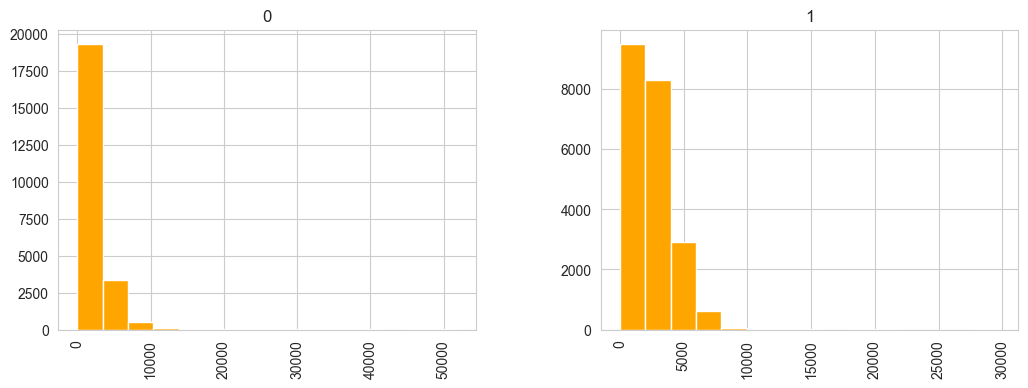

In [76]:
data_new.hist(column='length', by='truefalse', bins=15,figsize=(12,4),color='orange')
plt.show()

#### Etapa 7-5. Pré-processar os dados
O pré-processamento de dados consiste nas quatro etapas a seguir.
*

In [77]:
# Converter para minúsculas.
data_new['text'] = data_new['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(data_new['text'].head())

10129    washington (reuters) - the prospect of japan a...
17897    canberra (reuters) - australia is trying to mo...
10863    just two months shy of the one-year anniversar...
10439    why would president trump want america to enfo...
16457    judge jeanine gives us facts on the relationsh...
Name: text, dtype: object


In [78]:
# Remova a pontuação.
data_new['text'] = data_new['text'].str.replace('[^\w\s]','', regex=True)
print(data_new['text'].head())

10129    washington reuters  the prospect of japan and ...
17897    canberra reuters  australia is trying to move ...
10863    just two months shy of the oneyear anniversary...
10439    why would president trump want america to enfo...
16457    judge jeanine gives us facts on the relationsh...
Name: text, dtype: object


In [79]:
# Remova as palavras de parada. As stopwords são importadas da biblioteca nltk.
stop = stopwords.words('english')
data_new['text'] = data_new['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [80]:
# Fazendo a lemmatization.
from nltk.stem import WordNetLemmatizer

data_new['text'] = data_new['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_new['text'].head()

10129    washington reuters prospect japan south korea ...
17897    canberra reuters australia trying move asylum ...
10863    two month shy oneyear anniversary rich death f...
10439    would president trump want america enforce tra...
16457    judge jeanine give u fact relationship state d...
Name: text, dtype: object

#### Etapa 7-6. Usar train_test_split
A biblioteca train_test_split de sklearn.model_selection é importada para dividir o dataframe em duas partes.

In [81]:
data_new

,text,truefalse,length
10129,washington reuters prospect japan south korea ...,1,605
17897,canberra reuters australia trying move asylum ...,1,2099
10863,two month shy oneyear anniversary rich death f...,0,19525
10439,would president trump want america enforce tra...,0,1942
16457,judge jeanine give u fact relationship state d...,0,285
...,...,...,...
18527,manchester england reuters britain junior brex...,1,779
2411,new york reuters majority american ready move ...,1,3771
5598,president obama appeared campaign rally alongs...,0,1840
17797,yesterday man likely illegal alien arrested su...,0,5403


In [82]:
# divisão em dados de treinamento e teste

In [83]:
X = data_new['text']
y = data_new['truefalse']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=100, stratify=y)
#validar a forma do conjunto de dados de treinamento e teste
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(31428,)
(31428,)
(13470,)
(13470,)


#### Etapa 7-7. Faça engenharia de recursos
A biblioteca TfidfVectorizer (de sklearn.feature_extraction.text) gera os recursos do texto.

In [84]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data_new['text'])
xtrain_tfidf = tfidf_vect.transform(X_train)
xtest_tfidf = tfidf_vect.transform(X_test)

As características foram extraídas do texto. Vamos construir o modelo como um próximo passo.
#### Etapa 7-8. Construir um modelo
Este é um algoritmo de classificação com notícias falsas e notícias reais como classes. O texto foi convertido em recursos. Vamos tentar vários algoritmos de aprendizado de máquina para ver qual deles tem melhor precisão.

Os vários algoritmos levados em consideração para construir o modelo.
* Classificador Naive Bayes
* Classificador linear (regressão logística)
* Classificador de máquina de vetores de suporte
* Classificador de floresta aleatório

Vamos construir uma função generalizada que pode ser usada para vários algoritmos.

In [85]:
def train_model(classifier, feature_vector_train, label, feature_vector_test):
# fitting
    classifier.fit(feature_vector_train, label)
# predicting
    predictions = classifier.predict(feature_vector_test)
    return metrics.accuracy_score(predictions, y_test)

Vamos começar com o Naive Bayes.

In [86]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print ("Accuracy of Naive Bayes: ", accuracy)

Accuracy of Naive Bayes:  0.9293244246473645


O que se segue é a regressão logística.

In [87]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, y_train, xtest_tfidf)
print ("Accuracy of logistic regression: ", accuracy)

Accuracy of logistic regression:  0.9846325167037862


SVM

In [88]:
accuracy = train_model(svm.SVC(), xtrain_tfidf, y_train, xtest_tfidf)
print ("Accuracy of SVM: ", accuracy)

Accuracy of SVM:  0.9921306607275426


O seguinte é floresta aleatória.

In [89]:
accuracy = train_model(RandomForestClassifier(), xtrain_tfidf, y_train, xtest_tfidf)
print ("Accuracy of RandomForest: ", accuracy)

Accuracy of RandomForest:  0.997253155159614


Observação: O classificador linear binomial (regressão logística) é considerado o algoritmo mais adequado neste problema. Vamos construir o modelo novamente e entender outros parâmetros de precisão.

A função LogisticRegression() está presente na biblioteca linear_model no sklearn.

In [90]:
#fit the model
model=linear_model.LogisticRegression()
nb = model.fit(xtrain_tfidf,y_train)
nb

LogisticRegression()

O resultado do modelo classificador mostra a previsão na forma de uma matriz binária, onde 1 significa falso e 0 significa legítimo.

In [91]:
## Model Results:
predictions = nb.predict(xtest_tfidf)
predictions

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

#### Avaliação do modelo
O modelo do classificador pode ser avaliado com base em dois parâmetros.

1. Matriz de confusão
<p><img src=https://media-exp1.licdn.com/dms/image/C4D12AQE-hEJoe0y34w/article-inline_image-shrink_400_744/0/1538424289069?e=1673481600&v=beta&t=IfUirHIX5oexbZ2E1OF1SCLBVO8xyaHfeiAzMgeilv8 width=500> </p>

A seguir está o relatório da matriz de confusão para o modelo.

In [92]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=["Legit", "Fake"]))

              precision    recall  f1-score   support

       Legit       0.99      0.98      0.99      7045
        Fake       0.98      0.99      0.98      6425

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



2. Pontuação AUC (área sob a curva)
<p><img src= https://slideplayer.com.br/slide/2936106/10/images/27/AUC+para+diferentes+curvas+ROC.jpg width=700></p>

In [93]:
# AUC para o modelo construído.
from sklearn.metrics import roc_auc_score
nb_auc = roc_auc_score(y_test, nb.predict_proba(xtest_tfidf)[:, 1])
print("AUC for Model: {:.3f}".format(nb_auc))

AUC for Model: 0.998


A área sob a curva é de **56%**.
Você pode ver que há uma precisão de até **55%**. Você pode aumentar a precisão por meio de uma coleta de dados mais rotulada e ajustando os parâmetros. Vamos ver se o ajuste de hiperparâmetros pode aumentar a precisão.

#### Etapa 7-9. Ajustar hiperparâmetros
Vamos usar o ajuste do *grid search parameter*, que constrói e avalia metodicamente um modelo para cada combinação de parâmetros especificados em uma grade.
A seguir estão as etapas para ajuste de hiperparâmetros.
1. Importe os parâmetros do *grid*.

In [94]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 15,20,100]}

2. Ajuste o modelo

In [95]:
cf_model = linear_model.LogisticRegression()

3. Rode o *Grid Search*

In [96]:
grid_search = GridSearchCV(cf_model, param_grid, cv=5)

4. Ajustar o modelo nos dados de treinamento

In [97]:
grid_search.fit(xtrain_tfidf,y_train)

D:\WILLIAN\Anaconda3\envs\NLP_Recipes\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\WILLIAN\Anaconda3\envs\NLP_Recipes\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 15, 20, 100]})

5. Avaliar

In [98]:
print("Test set score: {:.2f}".format(grid_search.score(xtest_tfidf,y_test)))

Test set score: 0.99


6. Encontre os melhores parâmetros do modelo.

In [99]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100}
Best cross-validation score: 0.99


In [100]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
LogisticRegression(C=100)


7. Reconstrua o modelo usando esses parâmetros ajustados.

In [101]:
model=linear_model.LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
nb=model.fit(xtrain_tfidf, y_train)
nb

LogisticRegression(C=20, multi_class='ovr', n_jobs=1, solver='liblinear')

#### Etapa 7-10. Validar
Uma vez que o modelo tenha sido ajustado com os melhores parâmetros, ele é validado para verificar a precisão do modelo nos dados de texto. Os parâmetros de validação são os mesmos.
A seguir está o relatório da matriz de confusão para o modelo.

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,target_names=["Legit", "Fake"]))

              precision    recall  f1-score   support

       Legit       0.99      0.98      0.99      7045
        Fake       0.98      0.99      0.98      6425

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



AUC para o modelo ajustado.

In [103]:
from sklearn.metrics import roc_auc_score
nb_auc = roc_auc_score(y_test, nb.predict_proba(xtest_tfidf)[:, 1])
print("AUC for tuned SVC model: {:.3f}".format(nb_auc))

AUC for tuned SVC model: 1.000


#### Resumo
Esta receita construiu um modelo de linha de base para classificação de notícias falsas e usou um conjunto de dados rotulados de fonte gratuita de várias fontes de canais de notícias. Primeiro, você aprendeu como criar o conjunto de dados, pré-processar os dados e executar a engenharia de recursos usando TF-IDF. Mais tarde, você viu diferentes métodos de aprendizado de máquina para treinar o modelo. Por fim, você observou que um classificador linear teve melhor desempenho quando comparado a outros classificadores.

Há muito espaço para aumentar a precisão usando diferentes abordagens. Este é apenas o modelo de linha de base e você pode melhorar a precisão usando técnicas avançadas de engenharia de recursos, como incorporação de palavras. Você também pode usar métodos de aprendizado profundo para investigar se há alguma melhoria na precisão.

## Receita 5-8. Marcação de gênero de filme
A categorização multi-tag/rótulo decorre da busca por problemas de categorização de texto, cada um dos quais pode pertencer a vários temas predefinidos ao mesmo tempo. Por exemplo, isso pode encontrar os tipos de gênero aos quais um filme pertence com base em um resumo de seu desenho. Em uma classificação multirrótulo, um conjunto de aprendizado consiste em instâncias associadas a um conjunto de tags. A tarefa é prever um conjunto de tags de instância invisível analisando uma instância de aprendizado com um conjunto conhecido de tags.

A classificação multicategoria assume que cada amostra é atribuída a um e apenas um rótulo: o cliente pode ser churn ou não, mas não ambos. E, por exemplo, uma classificação multirrótulo pode significar que o texto pode lidar com religião, política, finanças, educação ou qualquer uma dessas coisas simultaneamente.
### Problema
Categorizar filmes em gêneros é um dos problemas clássicos da IA. Plataformas de reserva de filmes on-line e sites de resenhas, como IMDb, classificam os filmes em seus respectivos gêneros. Um gênero pode ser ação, aventura, comédia, romance e assim por diante. No IMDb, todo filme tem um gênero associado a ele. Mas o desafio é que um único filme também pode ter vários gêneros. Por exemplo, Avengers: Endgame está marcado nos gêneros de ação, aventura e fantasia.

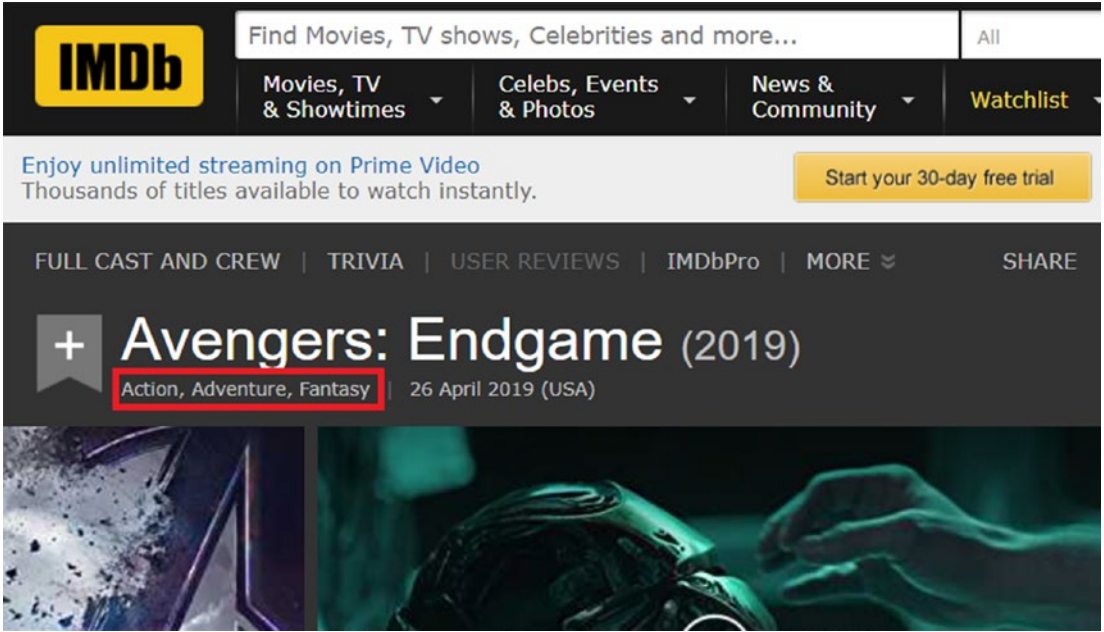

In [104]:
Image('images/imdb.png')

Nosso objetivo aqui é marcar gêneros de filmes, dada a descrição do filme. O modelo deve prever todas as classes possíveis (gêneros) às quais um filme pode pertencer. Embora você já tenha visto uma classificação multiclasse simples antes, esta receita explora como resolver um problema de aprendizado e classificação multirrótulo.
### Solução
Você encontrou muitos problemas de classificação, e todos eles eram problemas de classe binária ou multiclasse. Agora vamos explorar um tipo único de problema conhecido como aprendizado multirótulo para resolver a marcação de gênero de filme.

Então, o que é classificação multirrótulo ou comumente chamada de aprendizagem multirrótulo? O cenário em que cada observação (x) no conjunto de dados tem uma variável de destino (y) com várias categorias. Por exemplo, o nome do filme com a descrição é seu recurso independente e o gênero (ação, aventura, fantasia) associado é a variável dependente.

A seguir estão algumas maneiras de lidar com problemas multirótulo.
* Um contra o resto
* Correlação binária
* Cadeia de classificação
* Conjunto de rótulos

### Fluxo de abordagem
Mas antes disso, você precisa cuidar das tarefas usuais relacionadas ao texto. A seguir estão as etapas para resolver esse problema de ponta a ponta.
1. Pré-processamento e limpeza de dados
2. Geração de recursos
3. Análise exploratória de dados
4. Classificador multirrótulo
5. Validação e previsão

### Como funciona
#### Etapa 8-1. Colete dados
Estamos usando um conjunto de dados de fonte gratuita que já está rotulado. No entanto, apenas uma pequena parte dos dados é rotulada. Quanto maior a quantidade de dados, maior a precisão e o poder de generalização do modelo. Baixe o conjunto de dados em www.kaggle.com/cryptexcode/mpst-movie-plot- synopses-with-tags#mpst_full_data.csv.
#### Etapa 8-2. Instalar bibliotecas
Importe todas as bibliotecas básicas necessárias para tarefas de mineração de texto.

In [105]:
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer

#Machine Learning
from sklearn.model_selection import train_test_split

#### Etapa 8-3. Analise os dados
Importe o conjunto de dados que foi baixado anteriormente.

In [106]:
#Importing dataset
df = pd.read_csv('',encoding = 'ISO-8859-1')
df.shape

FileNotFoundError: [Errno 2] No such file or directory: ''